<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">卷积神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2024年1月14日</span></div>
</div>

实验环境：
- OS：Ubuntu 22.04.3 LTS (GNU/Linux 6.5.0-14-generic x86_64)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.3
- conda: miniconda 23.11.0
- python：3.10.13
- torch：2.1.1

In [1]:
import torch
from torch import nn
import numpy as np

from dataset import *
from utils import *

# 1-RNN

采用手动方式以及调用接口方式实现RNN，并在至少一种数据集上进行实验。

## 1. 手动实现RNN

In [2]:
class My_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

分别在空气质量和高速公路数据集上进行训练和测试。

Epoch [10/80], Train Loss: 0.0018, Train RMSE: 11.9963, Val Loss: 0.0002, Val RMSE: 4.232524, Time Use: 0.114s
Epoch [20/80], Train Loss: 0.0013, Train RMSE: 10.4577, Val Loss: 0.0003, Val RMSE: 4.763322, Time Use: 0.082s
Epoch [30/80], Train Loss: 0.0011, Train RMSE: 9.4457, Val Loss: 0.0002, Val RMSE: 3.598969, Time Use: 0.120s
Epoch [40/80], Train Loss: 0.0009, Train RMSE: 8.7482, Val Loss: 0.0002, Val RMSE: 4.021163, Time Use: 0.104s
Epoch [50/80], Train Loss: 0.0009, Train RMSE: 8.5890, Val Loss: 0.0003, Val RMSE: 4.524315, Time Use: 0.119s
Epoch [60/80], Train Loss: 0.0008, Train RMSE: 8.2690, Val Loss: 0.0001, Val RMSE: 3.069326, Time Use: 0.073s
Epoch [70/80], Train Loss: 0.0009, Train RMSE: 8.4104, Val Loss: 0.0001, Val RMSE: 2.901076, Time Use: 0.123s
Epoch [80/80], Train Loss: 0.0008, Train RMSE: 7.9812, Val Loss: 0.0001, Val RMSE: 2.861316, Time Use: 0.114s
Final result: Get best validation rmse 2.8410 at epoch 77, Total time 8.74s
Test result: Test RMSE: 7.461815370744335,

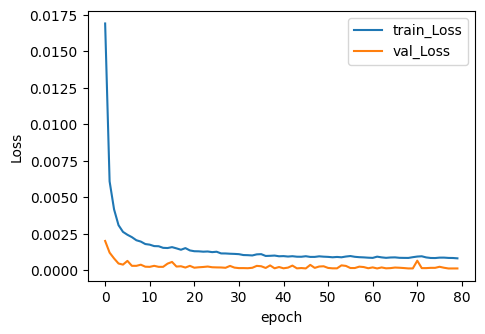

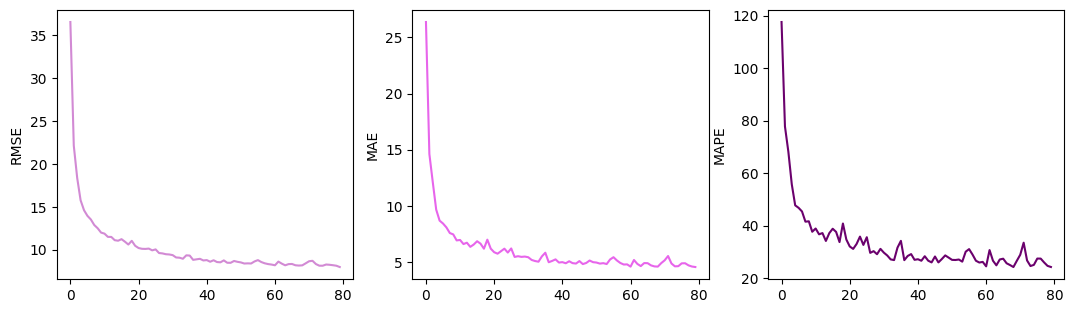

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.rnn = My_RNN(input_size, hidden_size, output_size).to(device)

    def forward(self, x):
        x, _ = self.rnn(x)
        return x[:, -1, :].squeeze(-1)


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    KrakowData = KrakowDataset()
    train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=KrakowData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

Epoch [10/80], Train Loss: 0.0027, Train RMSE: 59.2895, Val Loss: 0.0030, Val RMSE: 53.630808, Time Use: 0.205s
Epoch [20/80], Train Loss: 0.0024, Train RMSE: 55.8547, Val Loss: 0.0028, Val RMSE: 51.120778, Time Use: 0.217s
Epoch [30/80], Train Loss: 0.0023, Train RMSE: 54.2428, Val Loss: 0.0026, Val RMSE: 49.362866, Time Use: 0.223s
Epoch [40/80], Train Loss: 0.0022, Train RMSE: 53.0843, Val Loss: 0.0025, Val RMSE: 48.790776, Time Use: 0.214s
Epoch [50/80], Train Loss: 0.0022, Train RMSE: 53.2306, Val Loss: 0.0025, Val RMSE: 48.258740, Time Use: 0.226s
Epoch [60/80], Train Loss: 0.0022, Train RMSE: 53.2662, Val Loss: 0.0025, Val RMSE: 48.317744, Time Use: 0.224s
Epoch [70/80], Train Loss: 0.0022, Train RMSE: 53.0815, Val Loss: 0.0025, Val RMSE: 48.453326, Time Use: 0.239s
Epoch [80/80], Train Loss: 0.0022, Train RMSE: 53.0565, Val Loss: 0.0025, Val RMSE: 47.930591, Time Use: 0.217s
Final result: Get best validation rmse 47.8867 at epoch 60, Total time 16.28s
Test result: Test RMSE: 47

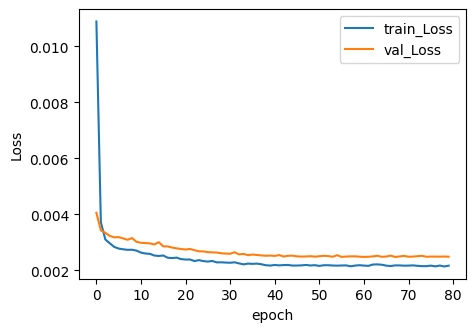

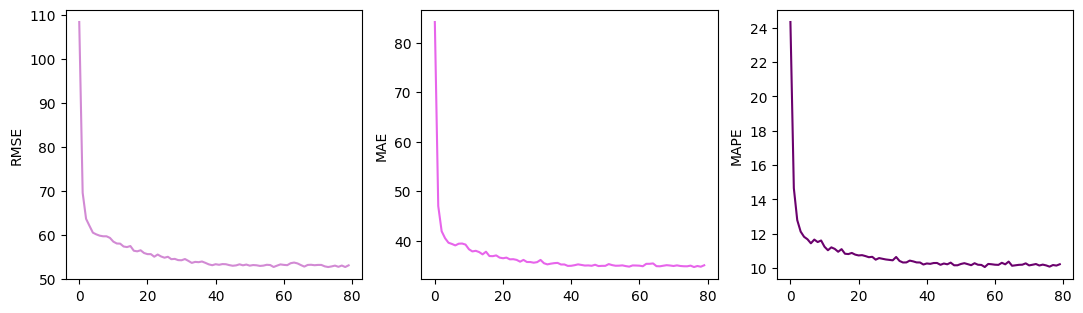

In [4]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    TrafficData = TrafficDataset()
    train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=TrafficData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

## 2. 调用`nn.RNN`接口

Epoch [10/80], Train Loss: 0.0020, Train RMSE: 12.7421, Val Loss: 0.0002, Val RMSE: 3.899864, Time Use: 0.043s
Epoch [20/80], Train Loss: 0.0015, Train RMSE: 11.0627, Val Loss: 0.0002, Val RMSE: 3.661664, Time Use: 0.043s
Epoch [30/80], Train Loss: 0.0013, Train RMSE: 10.1076, Val Loss: 0.0002, Val RMSE: 3.523567, Time Use: 0.042s
Epoch [40/80], Train Loss: 0.0011, Train RMSE: 9.3513, Val Loss: 0.0001, Val RMSE: 3.446217, Time Use: 0.045s
Epoch [50/80], Train Loss: 0.0010, Train RMSE: 8.7787, Val Loss: 0.0001, Val RMSE: 3.331583, Time Use: 0.042s
Epoch [60/80], Train Loss: 0.0009, Train RMSE: 8.3600, Val Loss: 0.0001, Val RMSE: 3.184500, Time Use: 0.042s
Epoch [70/80], Train Loss: 0.0008, Train RMSE: 8.1453, Val Loss: 0.0001, Val RMSE: 3.041168, Time Use: 0.044s
Epoch [80/80], Train Loss: 0.0008, Train RMSE: 8.1645, Val Loss: 0.0001, Val RMSE: 2.982300, Time Use: 0.042s
Final result: Get best validation rmse 2.9823 at epoch 79, Total time 3.44s
Test result: Test RMSE: 7.375547826139479

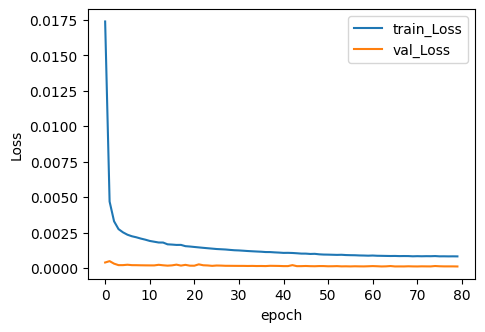

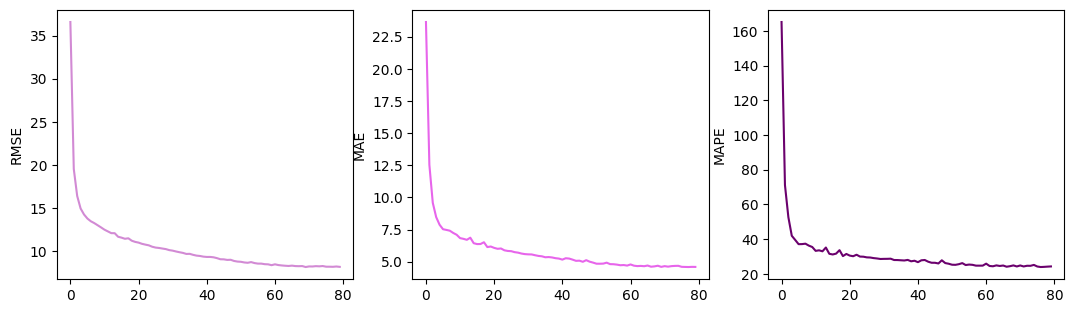

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :].squeeze(-1)
        x = self.fc(x).squeeze(-1)
        return x


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    KrakowData = KrakowDataset()
    train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=KrakowData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)

Epoch [10/80], Train Loss: 0.0029, Train RMSE: 60.9778, Val Loss: 0.0031, Val RMSE: 55.322961, Time Use: 0.081s
Epoch [20/80], Train Loss: 0.0026, Train RMSE: 57.9257, Val Loss: 0.0029, Val RMSE: 53.167723, Time Use: 0.080s
Epoch [30/80], Train Loss: 0.0025, Train RMSE: 56.5667, Val Loss: 0.0028, Val RMSE: 51.675393, Time Use: 0.083s
Epoch [40/80], Train Loss: 0.0024, Train RMSE: 55.7027, Val Loss: 0.0028, Val RMSE: 52.275445, Time Use: 0.082s
Epoch [50/80], Train Loss: 0.0023, Train RMSE: 54.7717, Val Loss: 0.0027, Val RMSE: 50.375122, Time Use: 0.083s
Epoch [60/80], Train Loss: 0.0022, Train RMSE: 53.9400, Val Loss: 0.0026, Val RMSE: 49.722526, Time Use: 0.080s
Epoch [70/80], Train Loss: 0.0022, Train RMSE: 53.9083, Val Loss: 0.0025, Val RMSE: 49.070341, Time Use: 0.081s
Epoch [80/80], Train Loss: 0.0022, Train RMSE: 53.2204, Val Loss: 0.0025, Val RMSE: 48.313175, Time Use: 0.082s
Final result: Get best validation rmse 48.3132 at epoch 79, Total time 6.52s
Test result: Test RMSE: 47.

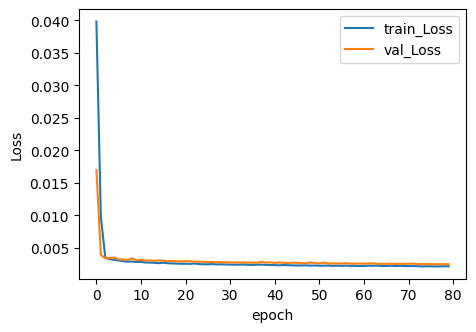

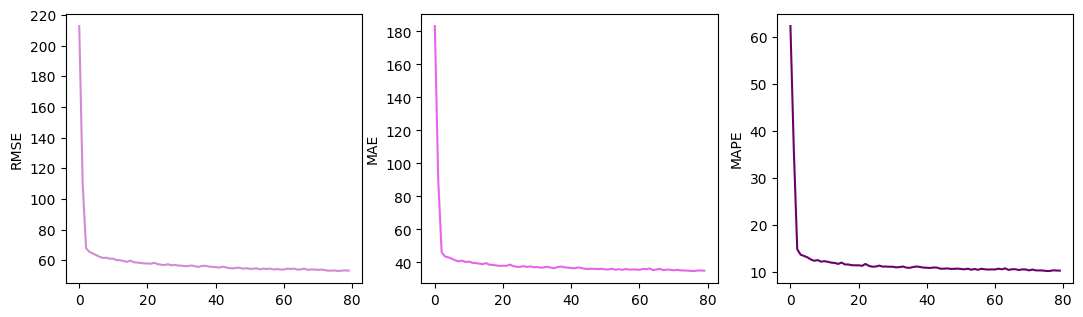

In [7]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    learning_rate = 1e-4
    num_epoch = 80
    
    TrafficData = TrafficDataset()
    train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
    input_size = train_set.seqs.shape[-1]
    seq_len = 12
    hidden_size = 512
    output_size = 1

    criterion = nn.MSELoss()
    model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
        net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
        denormalize_fn=TrafficData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
        device=device, num_print_epoch_round=10
    )
    visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
    plot_metric(train_score_lst)